--- Starting Part 1: MAML Training (2000 epochs) ---
Epoch 0: Meta Loss = 0.3555
Epoch 200: Meta Loss = 0.6035
Epoch 400: Meta Loss = 0.7599
Epoch 600: Meta Loss = 0.2518
Epoch 800: Meta Loss = 0.0818
Epoch 1000: Meta Loss = 0.5201
Epoch 1200: Meta Loss = 0.1547
Epoch 1400: Meta Loss = 0.0805
Epoch 1600: Meta Loss = 0.2371
Epoch 1800: Meta Loss = 0.2570
Epoch 2000: Meta Loss = 0.5361

--- Starting Part 2: Baseline Joint Training (2000 epochs) ---
Epoch 0: Baseline Loss = 0.6869
Epoch 200: Baseline Loss = 0.3352
Epoch 400: Baseline Loss = 0.3507
Epoch 600: Baseline Loss = 0.2498
Epoch 800: Baseline Loss = 0.2789
Epoch 1000: Baseline Loss = 0.1879
Epoch 1200: Baseline Loss = 0.4200
Epoch 1400: Baseline Loss = 0.3669
Epoch 1600: Baseline Loss = 0.1101
Epoch 1800: Baseline Loss = 0.4989
Epoch 2000: Baseline Loss = 0.6571

--- Generating Deliverables ---


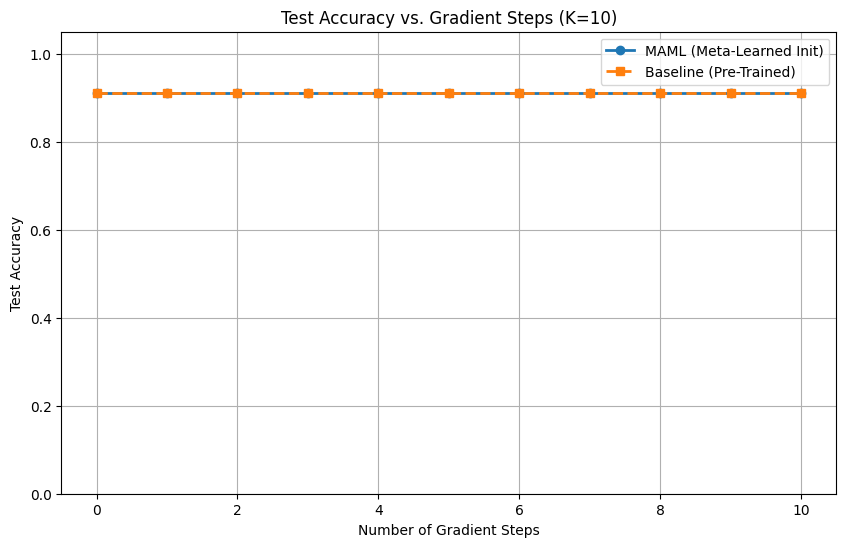

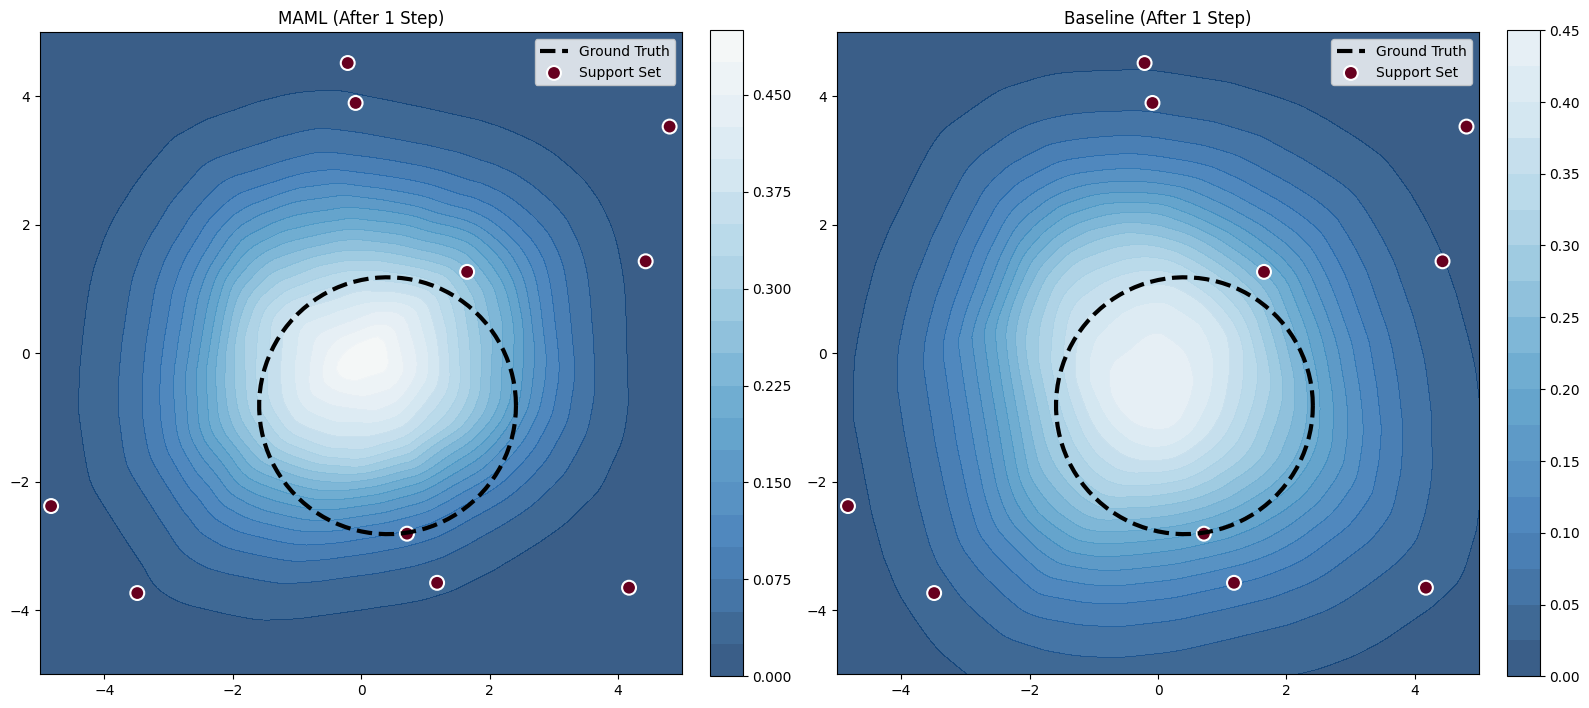

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

# --- 1. CONFIGURATION & SEEDING ---
torch.manual_seed(42)
np.random.seed(42)

CONFIG = {
    'k_shot': 10,          # Support set size (K=10)
    'q_query': 15,         # Query set size for meta-update
    'inner_lr': 0.1,       # Step size for inner loop (alpha)
    'meta_lr': 0.001,      # Step size for outer loop (beta)
    'meta_epochs': 2000,   # Outer loop epochs
    'baseline_epochs': 2000, # Baseline training epochs
    'radius': 2.0,         # Fixed radius of the circle
    'center_range': 3.0    # Range for circle centers [-3, 3]
}

# --- 2. DATASET: MOVING CIRCLE ---
class CircleTaskDistribution:
    def __init__(self):
        self.radius = CONFIG['radius']
        self.range_min = -5.0
        self.range_max = 5.0
        self.center_range = CONFIG['center_range']

    def sample_task(self):
        """Generates a random center (cx, cy) for a new task."""
        cx = np.random.uniform(-self.center_range, self.center_range)
        cy = np.random.uniform(-self.center_range, self.center_range)
        return (cx, cy)

    def get_data(self, center, num_samples):
        """Generates samples (x) and labels (y) for a specific circle task."""
        cx, cy = center
        # Input space x in [-5, 5]
        x = torch.FloatTensor(num_samples, 2).uniform_(self.range_min, self.range_max)

        # Calculate distance from center squared
        dist_sq = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2

        # Label 1 if inside radius, 0 otherwise
        y = (dist_sq < self.radius**2).float().unsqueeze(1)
        return x, y

    def get_task_batch(self, k_shot, q_query):
        """Returns support and query sets for a single task."""
        center = self.sample_task()
        support_x, support_y = self.get_data(center, k_shot)
        query_x, query_y = self.get_data(center, q_query)
        return support_x, support_y, query_x, query_y, center

# --- 3. MODEL ARCHITECTURE ---
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Define layers in a way we can access them by index in forward()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        """
        Forward pass allowing manual parameter injection for MAML.
        If params is None, uses the standard model parameters.
        """
        if params is None:
            return self.net(x)

        # Manual functional forward pass using the 'params' dictionary
        # We must explicitly use the weights corresponding to the layers in self.net

        # Layer 0: Linear
        x = torch.nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = torch.nn.functional.relu(x)

        # Layer 2: Linear
        x = torch.nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = torch.nn.functional.relu(x)

        # Layer 4: Linear (Output)
        x = torch.nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        x = torch.sigmoid(x)
        return x

def get_params(model):
    """Helper to extract parameters by name for manual updates."""
    return {name: param for name, param in model.named_parameters()}

# --- 4. PART 1: MAML IMPLEMENTATION ---
print(f"--- Starting Part 1: MAML Training ({CONFIG['meta_epochs']} epochs) ---")

task_dist = CircleTaskDistribution()
maml_model = SimpleMLP()
meta_optimizer = optim.Adam(maml_model.parameters(), lr=CONFIG['meta_lr'])
loss_fn = nn.BCELoss()

maml_history = []

for epoch in range(CONFIG['meta_epochs'] + 1):
    # 1. Sample a task
    sup_x, sup_y, q_x, q_y, _ = task_dist.get_task_batch(CONFIG['k_shot'], CONFIG['q_query'])

    # 2. Inner Loop (1 gradient step)
    weights = get_params(maml_model)

    # Compute loss on support set
    sup_pred = maml_model(sup_x, params=weights)
    inner_loss = loss_fn(sup_pred, sup_y)

    # Compute gradients (create_graph=True is crucial for MAML)
    grads = torch.autograd.grad(inner_loss, weights.values(), create_graph=True)

    # Update weights manually (Fast Weights)
    fast_weights = {}
    for (name, param), grad in zip(weights.items(), grads):
        fast_weights[name] = param - CONFIG['inner_lr'] * grad

    # 3. Meta Update
    # Compute loss on query set using fast weights
    q_pred = maml_model(q_x, params=fast_weights)
    meta_loss = loss_fn(q_pred, q_y)

    # Optimize meta-parameters
    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Meta Loss = {meta_loss.item():.4f}")
        maml_history.append(meta_loss.item())

# --- 5. PART 2: BASELINE COMPARISON (Standard Learning) ---
print(f"\n--- Starting Part 2: Baseline Joint Training ({CONFIG['baseline_epochs']} epochs) ---")

baseline_model = SimpleMLP()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=CONFIG['meta_lr'])
baseline_loss_fn = nn.BCELoss()

# For joint training, we sample random tasks and train on them sequentially.
# This forces the model to learn the "average" of all possible circles.
for epoch in range(CONFIG['baseline_epochs'] + 1):
    # Sample a random batch of data
    b_x, b_y, _, _, _ = task_dist.get_task_batch(k_shot=32, q_query=0)

    preds = baseline_model(b_x)
    loss = baseline_loss_fn(preds, b_y)

    baseline_optimizer.zero_grad()
    loss.backward()
    baseline_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Baseline Loss = {loss.item():.4f}")

# --- 6. EVALUATION & DELIVERABLES ---

def fine_tune_and_evaluate(model, test_task_data, steps=10, lr=0.1):
    """
    Fine-tunes a model on the support set of a specific task and evaluates
    accuracy on the query set at each gradient step.
    """
    sup_x, sup_y, test_x, test_y = test_task_data

    # Clone model so we don't mess up the original
    temp_model = copy.deepcopy(model)
    optimizer = optim.SGD(temp_model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    accuracies = []

    # Evaluate at step 0 (Pre-update)
    with torch.no_grad():
        preds = temp_model(test_x)
        predicted_labels = (preds > 0.5).float()
        acc = (predicted_labels == test_y).float().mean().item()
        accuracies.append(acc)

    # Fine-tune loop
    for step in range(steps):
        temp_model.train()
        sup_preds = temp_model(sup_x)
        loss = loss_fn(sup_preds, sup_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate
        temp_model.eval()
        with torch.no_grad():
            preds = temp_model(test_x)
            predicted_labels = (preds > 0.5).float()
            acc = (predicted_labels == test_y).float().mean().item()
            accuracies.append(acc)

    return accuracies, temp_model

# Generate a held-out test task
print("\n--- Generating Deliverables ---")
test_dist = CircleTaskDistribution()
# Get a task: 10 support examples, 100 query examples for robust evaluation
t_sup_x, t_sup_y, t_q_x, t_q_y, t_center = test_dist.get_task_batch(k_shot=10, q_query=100)
test_data = (t_sup_x, t_sup_y, t_q_x, t_q_y)

# 6.1 Quantitative Evaluation: Test Accuracy vs Steps
steps = 10
maml_accs, maml_finetuned = fine_tune_and_evaluate(maml_model, test_data, steps=steps, lr=CONFIG['inner_lr'])
baseline_accs, baseline_finetuned = fine_tune_and_evaluate(baseline_model, test_data, steps=steps, lr=CONFIG['inner_lr'])

plt.figure(figsize=(10, 6))
plt.plot(range(steps + 1), maml_accs, 'o-', label='MAML (Meta-Learned Init)', linewidth=2)
plt.plot(range(steps + 1), baseline_accs, 's--', label='Baseline (Pre-Trained)', linewidth=2)
plt.title(f'Test Accuracy vs. Gradient Steps (K={CONFIG["k_shot"]})')
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

# 6.2 Qualitative Visualization: Decision Boundary Heatmap
def get_heatmap_grid(model, resolution=100):
    x_range = np.linspace(-5, 5, resolution)
    y_range = np.linspace(-5, 5, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor).reshape(xx.shape)
    return xx, yy, preds

# We use the models AFTER 1 gradient step for visualization
_, maml_1step = fine_tune_and_evaluate(maml_model, test_data, steps=1, lr=CONFIG['inner_lr'])
_, base_1step = fine_tune_and_evaluate(baseline_model, test_data, steps=1, lr=CONFIG['inner_lr'])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Helper to plot ground truth circle
theta = np.linspace(0, 2*np.pi, 100)
cx, cy = t_center
gt_x = cx + CONFIG['radius'] * np.cos(theta)
gt_y = cy + CONFIG['radius'] * np.sin(theta)

models_to_plot = [('MAML (After 1 Step)', maml_1step), ('Baseline (After 1 Step)', base_1step)]

for i, (title, model) in enumerate(models_to_plot):
    xx, yy, preds = get_heatmap_grid(model)

    # Plot contour
    contour = axes[i].contourf(xx, yy, preds, levels=20, cmap='RdBu_r', alpha=0.8, vmin=0, vmax=1)

    # Plot ground truth boundary
    axes[i].plot(gt_x, gt_y, 'k--', linewidth=3, label='Ground Truth')

    # Plot Support Set points
    axes[i].scatter(t_sup_x[:,0], t_sup_x[:,1], c=t_sup_y.flatten(), cmap='RdBu',
                    edgecolors='white', s=100, linewidth=1.5, label='Support Set')

    axes[i].set_title(title)
    axes[i].set_xlim(-5, 5)
    axes[i].set_ylim(-5, 5)
    axes[i].set_aspect('equal') # Ensures circles look like circles
    axes[i].legend(loc='upper right')
    fig.colorbar(contour, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()